#EmoReflector
This project involves a social-interactive robot that provides the elderly by detecting their emotions to help them deal with it. To develop a machine-learning algorithm, PyTorch will be used.

##1. Load and Preprocess the Dataset


To load the dataset stored in google drive, the dataset must be mounted in Google Colab.

In [1]:
#from google.colab import drive
#drive.mount('/content/drive')

After mounting, the necessary packages for performing the deep-learning part must be imported as this will be used to insert into the Raspberry Pi.

In [6]:
import torch
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset, random_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
import cv2
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, confusion_matrix
import seaborn as sns

Graphics Preprocessing Units (GPU) divides tasks into smaller sub-tasks that are distributing among several processing cores. This results in faster processing of intensive high-resolution images and graphics like the data that will be used in our project.

In [8]:
# Setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

As the dataset was downloaded and not pre-installed in Pytorch, an image dataset was loaded. After loading the dataset, it has been preprocessed by removing the unnecessary column, dropping rows with missing values in 'label' column, renaming 'label' column to 'emotion' to make it clearer and finally, adding a necessary column 'is_negative' that classifies whether the emotions are negative or non-negative emotion. As our robot will only respond to negative emotions, adding 'is_negative' is a crucial step.  

In [9]:
#csv_file = '/content/drive/My Drive/EmoReflectorfiles/facedataset.csv'
#img_dir = '/content/drive/My Drive/EmoReflectorfiles/dataset'
csv_file = 'C:/Users/Ghulam/Downloads/GP machine learning part/facedataset.csv'
img_dir = 'C:/Users/Ghulam/Downloads/GP machine learning part/dataset'

class ImageDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        self.data = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform

        # Drop the 'Unnamed: 0' column if it exists
        if 'Unnamed: 0' in self.data.columns:
            self.data = self.data.drop(columns=['Unnamed: 0'])

        # Drop rows with missing values in the 'label' column and rename 'label' to 'emotion'
        self.data = self.data.dropna(subset=['label'])
        self.data = self.data.rename(columns={'label': 'emotion'})

        # Remove rows where the label is 'Ahegao'
        self.data = self.data[self.data['emotion'].str.lower() != 'ahegao']

        # Map emotions to integers
        self.emotion_to_idx = {emotion: idx for idx, emotion in enumerate(self.data['emotion'].unique())}
        self.data['emotion_idx'] = self.data['emotion'].map(self.emotion_to_idx)

        # Binary classification for is_negative (0 for non-negative, 1 for negative)
        self.data['is_negative'] = self.data['emotion'].apply(self.neg_nonneg_classifier).astype(int)

    def neg_nonneg_classifier(self, emotion):
        negative_emotions = ['angry', 'sad']
        nonnegative_emotions = ['neutral', 'happy', 'surprise']
        
        if emotion.lower() in negative_emotions:
            return 1
        elif emotion.lower() in nonnegative_emotions:
            return 0
        else:
            raise ValueError(f"Unexpected emotion: {emotion}")

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.data.iloc[idx, 0])
        image = Image.open(img_path).convert('RGB')
        
        # Emotion (multi-class label)
        emotion = torch.tensor(self.data.iloc[idx]['emotion_idx']).long()
        
        # Is_negative (binary label) should be an integer tensor (0 or 1)
        is_negative = torch.tensor(self.data.iloc[idx]['is_negative']).long()

        if self.transform:
            image = self.transform(image)

        return image, emotion, is_negative


Transformations are necessary to enhance the performance of our machine-learning model. It resizes all the images into 128 x 128 pixels, transforms the PIL images or NumPy array into tensors to scale the values accordingly and to normalize the tensor image by adjusting the pixels with a mean = 0.5 and standard deviation = 0.5.

In [10]:
# Define transformations
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

To check whether the loading and preprocessing was successful, a dataset was created and tested.

Note: Our dataset consists of 14248 files.

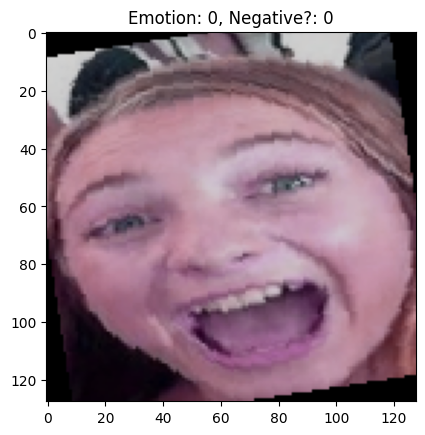

In [11]:
# Create the dataset
dataset = ImageDataset(csv_file=csv_file, img_dir=img_dir, transform=transform)

# Testing data
image, emotion, is_negative = dataset[1000] # Choose any number from 0 to 14247

# Convert tensor to numpy array
image_np = image.permute(1, 2, 0).numpy()

# Undo/reverse normalization to make the tensor back to image
image_np = (image_np * 0.5) + 0.5

# Clip values to be between 0 and 1 (just in case, to ensure that the pixels fall within valid pixel ranges to avoid incorrect visual outputs)
image_np = np.clip(image_np, 0, 1)

# Display the image
plt.imshow(image_np)
plt.title(f"Emotion: {emotion}, Negative?: {is_negative}")
plt.show()

In the steps below, we captured the face and stored the capture to identify position of the face. And then we identify the position using Haar Cascade classifier for face detection.

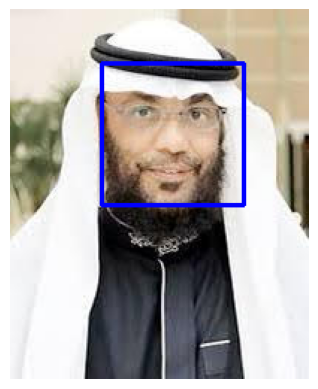

In [12]:
# Load the Haar Cascade classifier for face detection
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# Load the captured face
image_path = "C:/Users/Ghulam/Downloads/GP machine learning part/im1540.png"
image = cv2.imread(image_path)

# Check if the image was loaded successfully
if image is None:
    print(f"The image was unable to load at path: {image_path}")
else:
    # Convert the image to grayscale for face detection
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Detect faces in the grayscale image
    faces = face_cascade.detectMultiScale(gray_image, scaleFactor=1.1, minNeighbors=5)
    
    # Draw a blue rectangle around the detected faces on the original image
    for (x, y, w, h) in faces:
        cv2.rectangle(image, (x, y), (x + w, y + h), (255, 0, 0), 2)
    
    # Convert BGR to RGB for Matplotlib
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Display the image using Matplotlib
    plt.imshow(image_rgb)
    plt.axis('off')  # Hide axes
    plt.show()


#Defining CNN Model

In [ ]:
# Set the train-test split ratio
dataset_size = len(dataset)  # Total number of samples
train_size = int(0.8 * dataset_size)  # 80% for training
val_size = int(0.1 * dataset_size)    # 10% for validation
test_size = dataset_size - train_size - val_size  # Remaining 10% for testing
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Define batch size and create data loaders
batch_size = 32  
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

print(f"Dataset sizes - Train: {train_size}, Validation: {val_size}, Test: {test_size}")

Dataset sizes - Train: 11398, Validation: 1424, Test: 1426


In [13]:
# Set seed for reproducibility
torch.manual_seed(42)  

# Extract emotion labels from the dataset
emotion_labels = dataset.data['emotion_idx'].tolist()

# Train-test split with stratification
train_idx, test_idx = train_test_split(
    range(len(emotion_labels)),
    test_size=0.2,
    stratify=emotion_labels,
    random_state=42
)

# Create subsets using indices
train_dataset = torch.utils.data.Subset(dataset, train_idx)
test_dataset = torch.utils.data.Subset(dataset, test_idx)

# Define batch size
batch_size = 32 

# Create data loaders for each subset
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Train Loader: {len(train_loader)}, Test Loader: {len(test_loader)}")


Train Loader: 357, Test Loader: 90


In [22]:
class EmotionClassifierCNN(nn.Module):
    def __init__(self, num_emotion_classes):
        super(EmotionClassifierCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(128 * 16 * 16, 512)
        self.fc2_emotion = nn.Linear(512, num_emotion_classes)  #Output for emotion classification
        self.fc2_is_negative = nn.Linear(512, 1)  # Output for negative classification (binary)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 128 * 16 * 16)  # Flatten
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        emotion_output = self.fc2_emotion(x)
        is_negative_output = self.fc2_is_negative(x)
        return emotion_output, is_negative_output

# Initialize the model
num_emotion_classes = 5   #5 emotion classes
model = EmotionClassifierCNN(num_emotion_classes).to(device)


In [23]:
# Loss functions
criterion_emotion = nn.CrossEntropyLoss()  
criterion_is_negative = nn.BCEWithLogitsLoss()

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)

In [25]:
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, emotions, is_negatives in train_loader:
        images = images.to(device)
        emotions = emotions.to(device)
        is_negatives = is_negatives.unsqueeze(1).float().to(device)  # Reshape targets and move to device

        optimizer.zero_grad()

        # Forward pass
        emotion_output, is_negative_output = model(images)

        # Compute losses
        loss_emotion = criterion_emotion(emotion_output, emotions)
        loss_is_negative = criterion_is_negative(is_negative_output, is_negatives)  # No need to apply sigmoid here

        # Total loss
        loss = loss_emotion + loss_is_negative
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader)}")

Epoch 1, Loss: 0.006418934055403167
Epoch 1, Loss: 0.015805713936728256
Epoch 1, Loss: 0.023663715154183012
Epoch 1, Loss: 0.030154839283278008
Epoch 1, Loss: 0.03661643824323553
Epoch 1, Loss: 0.04292862822695607
Epoch 1, Loss: 0.04934704203565581
Epoch 1, Loss: 0.0557319423397716
Epoch 1, Loss: 0.06200786398238495
Epoch 1, Loss: 0.0682584030621526
Epoch 1, Loss: 0.07458294873811952
Epoch 1, Loss: 0.08063901706236083
Epoch 1, Loss: 0.08675335568874157
Epoch 1, Loss: 0.09256129772389303
Epoch 1, Loss: 0.09857578771788866
Epoch 1, Loss: 0.10525626829024456
Epoch 1, Loss: 0.11122794445155382
Epoch 1, Loss: 0.11709161432517343
Epoch 1, Loss: 0.12239586372001499
Epoch 1, Loss: 0.12926411461763354
Epoch 1, Loss: 0.13534554814090247
Epoch 1, Loss: 0.14183264252852326
Epoch 1, Loss: 0.1480121816239771
Epoch 1, Loss: 0.1543290758667206
Epoch 1, Loss: 0.16007584049588158
Epoch 1, Loss: 0.16615221714105258
Epoch 1, Loss: 0.17251931084972136
Epoch 1, Loss: 0.1787498594999981
Epoch 1, Loss: 0.1848

In [27]:
# Put the model in evaluation mode
model.eval()

# Initialize lists to store ground truths and predictions
train_true_emotions = []
train_pred_emotions = []
train_true_is_negatives = []
train_pred_is_negatives = []

# No gradient computation during evaluation
with torch.no_grad():
    for images, emotions, is_negatives in train_loader:
        # Move data to device
        images = images.to(device)
        emotions = emotions.to(device)
        is_negatives = is_negatives.to(device)

        # Forward pass
        emotion_output, is_negative_output = model(images)

        # Get predictions
        pred_emotions_batch = torch.argmax(emotion_output, dim=1).cpu().numpy()
        pred_is_negatives_batch = torch.argmax(is_negative_output, dim=1).cpu().numpy()

        # Append ground truths and predictions
        train_true_emotions.extend(emotions.cpu().numpy())
        train_pred_emotions.extend(pred_emotions_batch)
        train_true_is_negatives.extend(is_negatives.cpu().numpy())
        train_pred_is_negatives.extend(pred_is_negatives_batch)

# Calculate accuracy for emotion classification
emotion_train_accuracy = accuracy_score(train_true_emotions, train_pred_emotions)

# Calculate accuracy for is_negative classification
is_negative_train_accuracy = accuracy_score(train_true_is_negatives, train_pred_is_negatives)

# Print the results
print(f"Training Accuracy - Emotion Classification: {emotion_train_accuracy:.4f}")
print(f"Training Accuracy - Is_Negative Classification: {is_negative_train_accuracy:.4f}")

Training Accuracy - Emotion Classification: 0.7380
Training Accuracy - Is_Negative Classification: 0.6318


In [30]:
# Print the results
print(f"Training Accuracy - Emotion Classification: {emotion_train_accuracy * 100:.2f}%")
print(f"Training Accuracy - Is_Negative Classification: {is_negative_train_accuracy * 100:.2f}%")


Training Accuracy - Emotion Classification: 73.80%
Training Accuracy - Is_Negative Classification: 63.18%


Testing

Batch true_is_negatives size: 32
Batch pred_is_negatives size: 32
Batch true_is_negatives size: 32
Batch pred_is_negatives size: 32
Batch true_is_negatives size: 32
Batch pred_is_negatives size: 32
Batch true_is_negatives size: 32
Batch pred_is_negatives size: 32
Batch true_is_negatives size: 32
Batch pred_is_negatives size: 32
Batch true_is_negatives size: 32
Batch pred_is_negatives size: 32
Batch true_is_negatives size: 32
Batch pred_is_negatives size: 32
Batch true_is_negatives size: 32
Batch pred_is_negatives size: 32
Batch true_is_negatives size: 32
Batch pred_is_negatives size: 32
Batch true_is_negatives size: 32
Batch pred_is_negatives size: 32
Batch true_is_negatives size: 32
Batch pred_is_negatives size: 32
Batch true_is_negatives size: 32
Batch pred_is_negatives size: 32
Batch true_is_negatives size: 32
Batch pred_is_negatives size: 32
Batch true_is_negatives size: 32
Batch pred_is_negatives size: 32
Batch true_is_negatives size: 32
Batch pred_is_negatives size: 32
Batch true

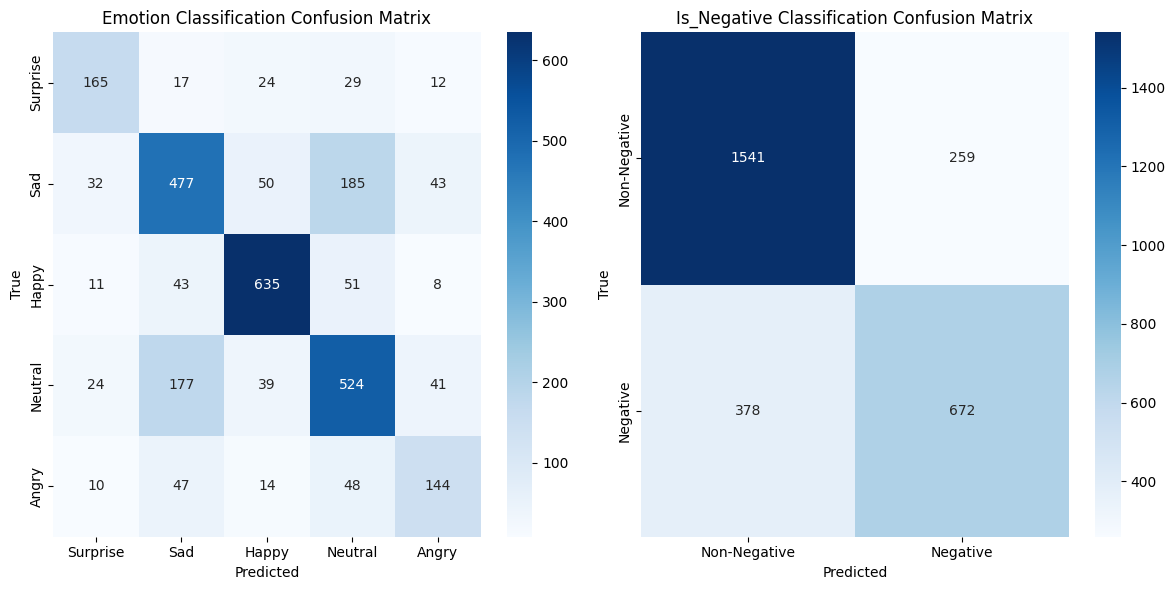

In [26]:
true_emotions = []
pred_emotions = []
true_is_negatives = []
pred_is_negatives = []

model.eval()
with torch.no_grad():
    for images, emotions, is_negatives in test_loader:
        # Move data to device
        images = images.to(device)
        emotions = emotions.to(device)
        is_negatives = is_negatives.to(device).view(-1, 1)  # Ensure correct shape

        # Forward pass
        emotion_output, is_negative_output = model(images)

        # Get predictions
        pred_emotions_batch = torch.argmax(emotion_output, dim=1).cpu().numpy()
        pred_is_negatives_batch = (torch.sigmoid(is_negative_output) > 0.5).long().cpu().numpy()

        # Append ground truths and predictions
        true_emotions.extend(emotions.cpu().numpy())
        pred_emotions.extend(pred_emotions_batch)
        true_is_negatives.extend(is_negatives.cpu().numpy())
        pred_is_negatives.extend(pred_is_negatives_batch)

        print(f"Batch true_is_negatives size: {len(is_negatives.cpu().numpy().flatten())}")
        print(f"Batch pred_is_negatives size: {len(pred_is_negatives_batch.flatten())}")


# Convert lists to numpy arrays
true_emotions = np.array(true_emotions)
pred_emotions = np.array(pred_emotions)
true_is_negatives = np.array(true_is_negatives)
pred_is_negatives = np.array(pred_is_negatives)

# Calculate metrics for emotion classification
emotion_f1 = f1_score(true_emotions, pred_emotions, average='weighted')
emotion_precision = precision_score(true_emotions, pred_emotions, average='weighted')
emotion_recall = recall_score(true_emotions, pred_emotions, average='weighted')
emotion_accuracy = accuracy_score(true_emotions, pred_emotions)
emotion_cm = confusion_matrix(true_emotions, pred_emotions)

# Calculate metrics for is_negative classification
is_negative_f1 = f1_score(true_is_negatives, pred_is_negatives)
is_negative_precision = precision_score(true_is_negatives, pred_is_negatives)
is_negative_recall = recall_score(true_is_negatives, pred_is_negatives)
is_negative_accuracy = accuracy_score(true_is_negatives, pred_is_negatives)
is_negative_cm = confusion_matrix(true_is_negatives, pred_is_negatives)

# Display results
print("Emotion Classification Metrics:")
print(f"F1 Score: {emotion_f1:.4f}")
print(f"Precision: {emotion_precision:.4f}")
print(f"Recall: {emotion_recall:.4f}")
print(f"Accuracy: {emotion_accuracy:.4f}")
print("Confusion Matrix:")
print(emotion_cm)

print("\nIs_Negative Classification Metrics:")
print(f"F1 Score: {is_negative_f1:.4f}")
print(f"Precision: {is_negative_precision:.4f}")
print(f"Recall: {is_negative_recall:.4f}")
print(f"Accuracy: {is_negative_accuracy:.4f}")
print("Confusion Matrix:")
print(is_negative_cm)

# Plot confusion matrices
plt.figure(figsize=(12, 6))

# Emotion classification confusion matrix
plt.subplot(1, 2, 1)
sns.heatmap(emotion_cm, annot=True, fmt="d", cmap="Blues", xticklabels=dataset.emotion_to_idx.keys(), yticklabels=dataset.emotion_to_idx.keys())
plt.title("Emotion Classification Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")

# Is_negative classification confusion matrix
plt.subplot(1, 2, 2)
sns.heatmap(is_negative_cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Non-Negative", "Negative"], yticklabels=["Non-Negative", "Negative"])
plt.title("Is_Negative Classification Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")

plt.tight_layout()
plt.show()



This is to walkthrough how many contents are in our image data directory (extra information).

In [ ]:
def walk_through_dir(dir_path):
  """
  Walks through dir_path returning its contents.
  Args:
    dir_path (str or pathlib.Path): target directory

  Returns:
    A print out of:
      number of subdiretories in dir_path
      number of images (files) in each subdirectory
      name of each subdirectory
  """
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

walk_through_dir(img_dir)

There are 5 directories and 0 images in '/content/drive/My Drive/EmoReflectorfiles/dataset'.
There are 0 directories and 1313 images in '/content/drive/My Drive/EmoReflectorfiles/dataset/Angry'.
There are 0 directories and 3934 images in '/content/drive/My Drive/EmoReflectorfiles/dataset/Sad'.
There are 0 directories and 1234 images in '/content/drive/My Drive/EmoReflectorfiles/dataset/Surprise'.
There are 0 directories and 4027 images in '/content/drive/My Drive/EmoReflectorfiles/dataset/Neutral'.
There are 0 directories and 3740 images in '/content/drive/My Drive/EmoReflectorfiles/dataset/Happy'.
